In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

!pip install wget
!sudo apt-get update
!apt-get install sox
#!sudo apt-get install -y sox
!pip install nemo_toolkit[asr]==0.10.0b10
!pip install unidecode

!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/BillyGun27/SpeechRecognitionDemo/main/jasper_an4.yaml

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 21.2MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9260daa1827e329a8a375b5e07d5ea82fa6a6fea6acfd74f531e6d95a1dd7c97
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubunt

In [16]:
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/quartznet_15x5.yaml
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/quartznet_15x5.yaml

--2020-10-21 08:35:53--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/quartznet_15x5.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5946 (5.8K) [text/plain]
Saving to: ‘configs/quartznet_15x5.yaml’

quartznet_15x5.yaml 100%[===================>]   5.81K  --.-KB/s    in 0s      

2020-10-21 08:35:53 (77.4 MB/s) - ‘configs/quartznet_15x5.yaml’ saved [5946/5946]



In [18]:
!wget -nc -q --show-progress -O quartznet15x5.zip https://api.ngc.nvidia.com/v2/models/nvidia/multidataset_quartznet15x5/versions/1/zip
!unzip quartznet15x5.zip && mkdir quartznet15x5_multidataset && mv Jasper* quartznet15x5.yaml quartznet15x5_multidataset

quartznet15x5.zip   100%[===================>]  67.86M  44.7MB/s    in 1.5s    
Archive:  quartznet15x5.zip
  inflating: JasperDecoderForCTC-STEP-243800.pt  
  inflating: JasperEncoder-STEP-243800.pt  
  inflating: quartznet15x5.yaml      


# Introduction to End-To-End Automatic Speech Recognition

This notebook contains a basic tutorial of Automatic Speech Recognition (ASR) concepts, introduced with code snippets using the [NeMo framework](https://github.com/NVIDIA/NeMo).
We will first introduce the basics of the main concepts behind speech recognition, then explore concrete examples of what the data looks like and walk through putting together a simple end-to-end ASR pipeline.

We assume that you are familiar with general machine learning concepts and can follow Python code, and we'll be using the [AN4 dataset from CMU](http://www.speech.cs.cmu.edu/databases/an4/) (with processing using `sox`).

## Conceptual Overview: What is ASR?

ASR, or **Automatic Speech Recognition**, refers to the problem of getting a program to automatically transcribe spoken language (speech-to-text). Our goal is usually to have a model that minimizes the **Word Error Rate (WER)** metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

Traditional speech recognition takes a generative approach, modeling the full pipeline of how speech sounds are produced: from a **language model** that encapsulates likely orderings of words (e.g. an n-gram model), to a **pronunciation model** for each word in the vocabulary (e.g. a pronunciation table), to an **acoustic model** that translates the pronunciations to audio waveforms (e.g. a Gaussian Mixture Model), and so on.

Then, if we receive some spoken input, our goal would be to find the most likely sequence of text that would result in the given audio according to our pipeline of models. Overall, with traditional speech recognition, we try to model `Pr(audio|transcript)*Pr(transcript)`, and take the argmax of this over possible transcripts.

Over time, neural nets advanced to the point where each component of the traditional speech recognition model could be replaced by a neural model that had better performance and that had a greater potential for generalization. For example, we could replace an n-gram model with a neural language model, and replace a pronunciation table with a neural pronunciation model, and so on. However, each of these neural models need to be trained individually on different tasks, and errors in any model in the pipeline could throw off the whole prediction.

Thus, we can see the appeal of **end-to-end ASR architectures**--discriminative models that simply take an audio input and give a textual output, and in which all components are trained together towards the same goal. A much easier pipeline to handle!

### End-To-End ASR

With an end-to-end model, we want to directly learn `Pr(transcript|audio)` in order to predict the transcripts from the original audio. Since we are dealing with sequential information--audio data over time that corresponds to a sequence of letters--RNNs are the obvious choice. But now we have a pressing problem to deal with: **since our input sequence (number of audio timesteps) is not the same length as our desired output (transcript length)**, how do we match each time step from the audio data to the correct output characters?

Earlier speech recognition approaches relied on **temporally-aligned data**, in which each segment of time in an audio file was matched up to a corresponding speech sound such as a phoneme or word. However, if we would like to have the flexibility to predict letter-by-letter to prevent **OOV** (out of vocabulary) issues, then each time step in the data would have to be labeled with the letter sound that the speaker is making at that point in the audio file. With that information, it seems like we should simply be able to try to predict the correct letter for each time step and then collapse the repeated letters (e.g. the prediction output `LLLAAAAPPTOOOPPPP` would become `LAPTOP`). It turns out that this idea has some problems: not only does alignment make the dataset incredibly labor-intensive to label, but also, what do we do with words like "book" that contain consecutive repeated letters? Simply squashing repeated letters together would not work in that case!

![Alignment example](https://leimao.github.io/images/blog/2019-11-02-CTC-Alignment-Combinations/ctc_loss.png)

Modern end-to-end approaches get around this using methods that don't require manual alignment at all, so that the input-output pairs are really just the raw audio and the transcript--no extra data or labeling required. Let's briefly go over two popular approaches that allow us to do this, Connectionist Temporal Classification (CTC) and sequence-to-sequence models with attention.

#### Connectionist Temporal Classification (CTC)

In normal speech recognition prediction output, we would expect to have characters such as the letters from A through Z, numbers 0 through 9, spaces ("\_"), and so on. CTC introduces a new intermediate output token called the **blank token** ("-") that is useful for getting around the alignment issue.

With CTC, we still predict one token per time segment of speech, but we use the blank token to figure out where we can and can't collapse the predictions. The appearance of a blank token helps separate repeating letters that should not be collapsed. For instance, with an audio snippet segmented into `T=11` time steps, we could get predictions that look like `BOO-OOO--KK`, which would then collapse to `"BO-O-K"`, and then we would remove the blank tokens to get our final output, `BOOK`.

Now, we can predict one output token per time step, then collapse and clean to get sensible output without any fear of ambiguity from repeating letters! A simple way of getting predictions like this would be to apply a bidirectional RNN to the audio input, apply softmax over each time step's output, and then take the token with the highest probability. The method of always taking the best token at each time step is called **greedy decoding, or max decoding**.

To calculate our loss for backprop, we would like to know the log probability of the model producing the correct transcript, `log(Pr(transcript|audio))`. We can get the log probability of a single intermediate output sequence (e.g. `BOO-OOO--KK`) by summing over the log probabilities we get from each token's softmax value, but note that the resulting sum is different from the log probability of the transcript itself (`BOOK`). This is because there are multiple possible output sequences of the same length that can be collapsed to get the same transcript (e.g. `BBO--OO-KKK` also results in `BOOK`), and so we need to **marginalize over every valid sequence of length `T` that collapses to the transcript**.

Therefore, to get our transcript's log probability given our audio input, we must sum the log probabilities of every sequence of length `T` that collapses to the transcript (e.g. `log(Pr(output: "BOOK"|audio)) = log(Pr(BOO-OOO--KK|audio)) + log(Pr(BBO--OO-KKK|audio)) + ...`). In practice, we can use a dynamic programming approach to calculate this, accumulating our log probabilities over different "paths" through the softmax outputs at each time step.

If you would like a more in-depth explanation of how CTC works, or how we can improve our results by using a modified beam search algorithm, feel free to check out the Further Reading section at the end of this notebook for more resources.

#### Sequence-to-Sequence with Attention

One problem with CTC is that predictions at different time steps are conditionally independent, which is an issue because the words in a continuous utterance tend to be related to each other in some sensible way. With this conditional independence assumption, we can't learn a language model that can represent such dependencies, though we can add a language model on top of the CTC output to mitigate this to some degree.

A popular alternative is to use a sequence-to-sequence model with attention. A typical seq2seq model for ASR consists of some sort of **bidirectional RNN encoder** that consumes the audio sequence timestep-by-timestep, and where the outputs are then passed to an **attention-based decoder**. Each prediction from the decoder is based on attending to some parts of the entire encoded input, as well as the previously outputted tokens.

The outputs of the decoder can be anything from word pieces to phonemes to letters, and since predictions are not directly tied to time steps of the input, we can just continue producing tokens one-by-one until an end token is given (or we reach a specified max output length). This way, we do not need to deal with audio alignment, and our predicted transcript is just the sequence of outputs given by our decoder.

Now that we have an idea of what some popular end-to-end ASR models look like, let's take a look at the audio data we'll be working with for our example.

## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. Please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step (see the "Downloads" section of the main page).

In [2]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [3]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

# Untar and convert .sph to .wav (using sox)
tar = tarfile.open(an4_path)
tar.extractall(path=data_dir)

print("Converting .sph to .wav...")
sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
for sph_path in sph_list:
    wav_path = sph_path[:-4] + '.wav'
    cmd = ["sox", sph_path, wav_path]
    subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./an4_sphere.tar.gz
Converting .sph to .wav...
Finished conversion.
******


You should now have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one (feel free to check this out by listening to `./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav`). In an ASR task, the WAV file would be our input, and "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

In [21]:
%matplotlib inline
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

# Plot our example audio file's waveform
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

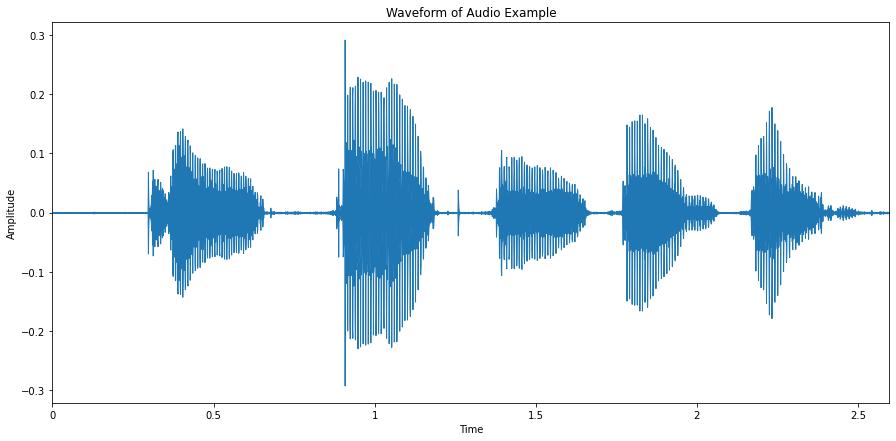

In [22]:
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

In [5]:
print(audio)
print(sample_rate)

[-2.5079990e-04 -2.0694929e-04  6.8230423e-05 ...  1.8096938e-03
  1.9291214e-03  1.2383324e-03]
22050


We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

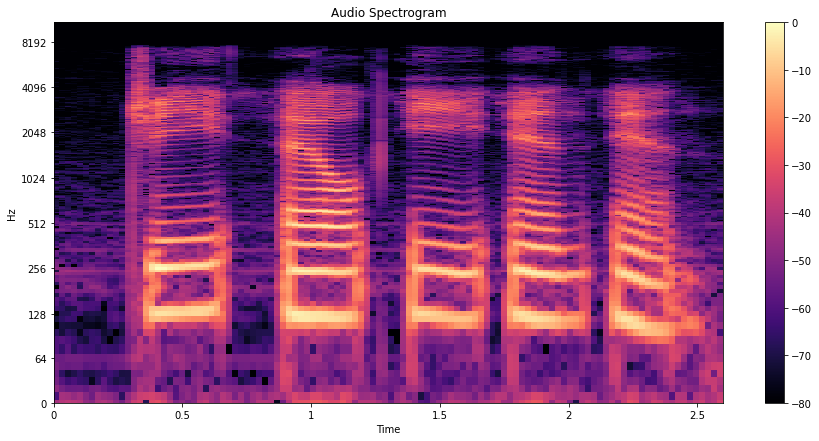

In [6]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we are able to see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

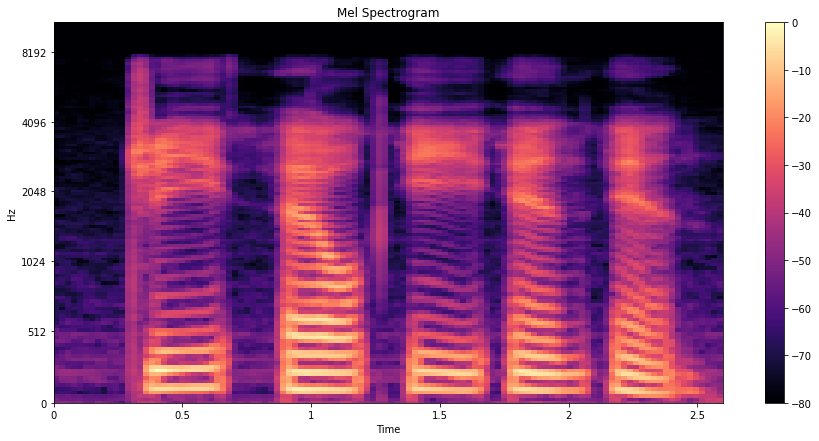

In [7]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

## Building a Simple ASR Pipeline in NeMo

Now that we have an idea of what the audio data looks like, we can start building our end-to-end ASR pipeline!

We'll be using the **Neural Modules (NeMo) toolkit** for this part, so if you haven't already, you should download and install NeMo and its dependencies. To do so, just follow the directions on the [GitHub page](https://github.com/NVIDIA/NeMo), or in the [documentation](https://nvidia.github.io/NeMo/).

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. If you're curious, you can read more about NeMo and how it works in the documentation pages linked above.

In [8]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection
import nemo.collections.asr as nemo_asr

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/usr/local/lib/python3.6/dist-packages/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')
/usr/local/lib/python3.6/dist-packages/nemo/collections/asr/audio_preprocessing.py:52: UserWarning: Unable to import APEX. Mixed precision and distributed training will not work.
  warnings.warn("Unable to import APEX. Mixed precision and distributed training will not work.")


### Creating Data Manifests

The first thing we need to do now is to create manifests for our training and evaluation data, which will contain the metadata of our audio files. NeMo data layers take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

Here's an example of what one line in a NeMo-compatible manifest might look like:
```
{"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}
```

We can build our training and evaluation manifests using `an4/etc/an4_train.transcription` and `an4/etc/an4_test.transcription`, which have lines containing transcripts and their corresponding audio file IDs:
```
...
<s> P I T T S B U R G H </s> (cen5-fash-b)
<s> TWO SIX EIGHT FOUR FOUR ONE EIGHT </s> (cen7-fash-b)
...
```

In [9]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
print("Test manifest created.")
print("******")

******
Training manifest created.
Test manifest created.
******


### Building Training and Evaluation DAGs

Let's take a look at the model that we will be building, and how we specify its parameters.

#### The Jasper Model

We will be putting together a small [Jasper (Just Another SPeech Recognizer) model](https://arxiv.org/abs/1904.03288).
In brief, Jasper architectures consist of a repeated block structure that utilizes 1D convolutions.
In a Jasper_KxR model, `R` sub-blocks (consisting of a 1D convolution, batch norm, ReLU, and dropout) are grouped into a single block, which is then repeated `K` times.
We also have a one extra block at the beginning and a few more at the end that are invariant of `K` and `R`, and we use CTC loss.

A Jasper model looks like roughly this:

![Jasper with CTC](https://raw.githubusercontent.com/NVIDIA/NeMo/master/docs/sources/source/asr/jasper_vertical.png)

#### Specifying Our Model with a YAML Config File

For this tutorial, we'll build a *Jasper_4x1 model*, with `K=4` blocks of single (`R=1`) sub-blocks and a *greedy CTC decoder*, using the configuration found in `./configs/jasper_an4.yaml`.

If we open up this config file, we find that there is an entry labeled `JasperEncoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:
```
- filters: 256
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
```
The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of `K` and `R`.
Next, we have four entries that correspond to the `K=4` blocks, and each has `repeat: 1` since we are using `R=1`.
These are followed by two more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify that we should be shuffling our training data but not our evaluation data (see `AudioToTextDataLayer_train` and `AudioToTextDataLayer_eval`), and some specifications for preprocessing and converting the audio data (in `AudioToMelSpectrogramPreprocessor`).

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

#### Building Training and Evaluation DAGs with NeMo

Building a model using NeMo consists of (1) instantiating the neural modules we need and (2) specifying the DAG by linking them together.

In NeMo, **the training and inference pipelines are managed by a `NeuralModuleFactory`**, which takes care of checkpointing, callbacks, and logs, along with other details in training and inference. We set its `log_dir` argument to specify where our model logs and outputs will be written, and can set other training and inference settings in its constructor. For instance, if we were **resuming training from a checkpoint**, we would set the argument `checkpoint_dir=<path_to_checkpoint>`.

Along with logs in NeMo, you can optionally view the tensorboard logs with the `create_tb_writer=True` argument to the `NeuralModuleFactory`. By default all the tensorboard log files will be stored in `{log_dir}/tensorboard`, but you can change this with the `tensorboard_dir` argument. One can load tensorboard logs through tensorboard by running `tensorboard --logdir=<path_to_tensorboard dir>` in the terminal.

In [10]:
# Create our NeuralModuleFactory, which will oversee the neural modules.
neural_factory = nemo.core.NeuralModuleFactory(
    log_dir=data_dir+'/an4_tutorial/',
    create_tb_writer=True)

logger = nemo.logging

Note that if you would like your pipeline to support running on CPU, you should
instead add these imports and then add an additional 'placement' argument:

```python
import torch
from nemo.core import DeviceType

neural_factory = nemo.core.NeuralModuleFactory(
    log_dir=data_dir+'/an4_tutorial/',
    placement=(DeviceType.GPU if torch.cuda.is_available() else DeviceType.CPU)
    )
```

Now that we have our neural module factory, we can **specify our neural modules and instantiate them**. Here, we load the parameters for each module from the configuration file using `import_from_config`. For the module parameters that we can't read directly from the config file or want to overwrite, we can use the `overwrite_params` argument.

## jasper_an4yaml 


```
# jasper_an4yaml

model: "Jasper"
sample_rate: &sample_rate 16000
dropout: &drop 0.0
repeat:  &rep  1

labels: &labels [" ", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
         "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "'"]


AudioToTextDataLayer_train:
    header:
        full_spec: nemo.collections.asr.AudioToTextDataLayer
    init_params:
        sample_rate: *sample_rate
        labels: *labels
        batch_size: 48
        shuffle: true


AudioToTextDataLayer_eval:
    header:
        full_spec: nemo.collections.asr.AudioToTextDataLayer
    init_params:
        sample_rate: *sample_rate
        labels: *labels
        batch_size: 64
        shuffle: false


AudioToMelSpectrogramPreprocessor:
    header:
        full_spec: nemo.collections.asr.AudioToMelSpectrogramPreprocessor
    init_params:
        normalize: "per_feature"
        window_size: 0.02
        sample_rate: *sample_rate
        window_stride: 0.01
        window: "hann"
        features: &n_mels 64
        n_fft: 512
        frame_splicing: 1
        dither: 0.00001
        stft_conv: true

JasperEncoder:
    header:
        full_spec: nemo.collections.asr.JasperEncoder
    init_params:
        feat_in: *n_mels
        activation: "relu"

        jasper:
            -   filters: 128
                repeat: 1
                kernel: [11]
                stride: [1]
                dilation: [1]
                dropout: *drop
                residual: true

            -   filters: 256
                repeat: *rep
                kernel: [13]
                stride: [1]
                dilation: [1]
                dropout: *drop
                residual: true

            -   filters: 256
                repeat: *rep
                kernel: [15]
                stride: [1]
                dilation: [1]
                dropout: *drop
                residual: true

            -   filters: 256
                repeat: *rep
                kernel: [17]
                stride: [1]
                dilation: [1]
                dropout: *drop
                residual: true

            -   filters: 256
                repeat: *rep
                kernel: [19]
                stride: [1]
                dilation: [1]
                dropout: *drop
                residual: true

            -   filters: 256
                repeat: 1
                kernel: [21]
                stride: [1]
                dilation: [1]
                dropout: 0.0
                residual: false

            -   filters: &enc_feat_out 1024
                repeat: 1
                kernel: [1]
                stride: [1]
                dilation: [1]
                dropout: 0.0
                residual: false

JasperDecoderForCTC:
    header:
        full_spec: nemo.collections.asr.JasperDecoderForCTC
    init_params:
        feat_in: *enc_feat_out

```




In [11]:
# --- Config Information ---#
from ruamel.yaml import YAML

config_path =  'configs/jasper_an4.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
labels = params['labels'] # Vocab

# --- Instantiate Neural Modules --- #

# Create training and test data layers (which load data) and data preprocessor
data_layer_train = nemo_asr.AudioToTextDataLayer.import_from_config(
    config_path,
    "AudioToTextDataLayer_train",
    overwrite_params={"manifest_filepath": train_manifest}
) # Training datalayer

data_layer_test = nemo_asr.AudioToTextDataLayer.import_from_config(
    config_path,
    "AudioToTextDataLayer_eval",
    overwrite_params={"manifest_filepath": test_manifest}
) # Eval datalayer

data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor.import_from_config(
    config_path, "AudioToMelSpectrogramPreprocessor"
)

# Create the Jasper_4x1 encoder as specified, and a CTC decoder
encoder = nemo_asr.JasperEncoder.import_from_config(
    config_path, "JasperEncoder"
)

decoder = nemo_asr.JasperDecoderForCTC.import_from_config(
    config_path, "JasperDecoderForCTC",
    overwrite_params={"num_classes": len(labels)}
)

ctc_loss = nemo_asr.CTCLossNM(num_classes=len(labels))
greedy_decoder = nemo_asr.GreedyCTCDecoder()

[NeMo I 2020-10-21 09:08:05 collections:138] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2020-10-21 09:08:05 collections:139] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-10-21 09:08:05 neural_modules:363] Instantiated a new Neural Module of type `AudioToTextDataLayer` using configuration loaded from the `configs/jasper_an4.yaml` file
[NeMo I 2020-10-21 09:08:05 collections:138] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2020-10-21 09:08:05 collections:139] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-10-21 09:08:05 neural_modules:363] Instantiated a new Neural Module of type `AudioToTextDataLayer` using configuration loaded from the `configs/jasper_an4.yaml` file
[NeMo I 2020-10-21 09:08:05 features:144] PADDING: 16
[NeMo I 2020-10-21 09:08:05 features:152] STFT using conv
[NeMo I 2020-10-21 09:08:10 neural_modules:363] Instantiated a new Neural Module of type `AudioToMelSpectrogramPreprocessor` using configuration loaded from the `

The next step is to assemble our training DAG by specifying the inputs to each neural module.

In [12]:
# --- Assemble Training DAG --- #
audio_signal, audio_signal_len, transcript, transcript_len = data_layer_train()

processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)

encoded, encoded_len = encoder(
    audio_signal=processed_signal,
    length=processed_signal_len)

log_probs = decoder(encoder_output=encoded)
preds = greedy_decoder(log_probs=log_probs)  # Training predictions
loss = ctc_loss(
    log_probs=log_probs,
    targets=transcript,
    input_length=encoded_len,
    target_length=transcript_len)

We would like to be able to evaluate our model on the test set, as well, so let's set up the evaluation DAG.

Our **evaluation DAG will reuse most of the parts of the training DAG with the exception of the data layer**, since we are loading the evaluation data from a different file but evaluating on the same model. Note that if we were using data augmentation in training, we would also leave that out in the evaluation DAG.

In [13]:
# --- Assemble Validation DAG --- #
(audio_signal_test, audio_len_test,
 transcript_test, transcript_len_test) = data_layer_test()

processed_signal_test, processed_len_test = data_preprocessor(
    input_signal=audio_signal_test,
    length=audio_len_test)

encoded_test, encoded_len_test = encoder(
    audio_signal=processed_signal_test,
    length=processed_len_test)

log_probs_test = decoder(encoder_output=encoded_test)
preds_test = greedy_decoder(log_probs=log_probs_test)  # Test predictions
loss_test = ctc_loss(
    log_probs=log_probs_test,
    targets=transcript_test,
    input_length=encoded_len_test,
    target_length=transcript_len_test)

### Running the Model

We would like to be able to monitor our model while it's training, so we use **callbacks**. In general, *callbacks are functions that are called at specific intervals over the course of training or inference*, such as at the start or end of every *n* iterations, epochs, etc. The callbacks we'll be using for this are the `SimpleLossLoggerCallback`, which reports the training loss (or another metric of your choosing, such as WER for ASR tasks), and the `EvaluatorCallback`, which regularly evaluates the model on the test set. Both of these callbacks require you to pass in the tensors to be evaluated--these would be the final outputs of the training and eval DAGs above.

Another useful callback is the `CheckpointCallback`, for saving checkpoints at set intervals. We create one here just to demonstrate how it works.

In [14]:
# --- Create Callbacks --- #

# We use these imports to pass to callbacks more complex functions to perform.
from nemo.collections.asr.helpers import monitor_asr_train_progress, \
    process_evaluation_batch, process_evaluation_epoch
from functools import partial

train_callback = nemo.core.SimpleLossLoggerCallback(
    # Notice that we pass in loss, predictions, and the transcript info.
    # Of course we would like to see our training loss, but we need the
    # other arguments to calculate the WER.
    tensors=[loss, preds, transcript, transcript_len],
    # The print_func defines what gets printed.
    print_func=partial(
        monitor_asr_train_progress,
        labels=labels),
    tb_writer=neural_factory.tb_writer
    )

# We can create as many evaluation DAGs and callbacks as we want,
# which is useful in the case of having more than one evaluation dataset.
# In this case, we only have one.
eval_callback = nemo.core.EvaluatorCallback(
    eval_tensors=[loss_test, preds_test, transcript_test, transcript_len_test],
    user_iter_callback=partial(
        process_evaluation_batch, labels=labels),
    user_epochs_done_callback=process_evaluation_epoch,
    eval_step=500,  # How often we evaluate the model on the test set
    tb_writer=neural_factory.tb_writer
    )

checkpoint_saver_callback = nemo.core.CheckpointCallback(
    folder=data_dir+'/an4_checkpoints',
    step_freq=1000  # How often checkpoints are saved
    )

if not os.path.exists(data_dir+'/an4_checkpoints'):
    os.makedirs(data_dir+'/an4_checkpoints')

Now that we have our model and callbacks set up, **how do we run it**?

Once we create our neural factory and the callbacks for the information that we want to see, we can **start training** by simply calling the train function on the tensors we want to optimize and our callbacks!

In [15]:
# --- Start Training! --- #
neural_factory.train(
    tensors_to_optimize=[loss],
    callbacks=[train_callback, eval_callback, checkpoint_saver_callback],
    optimizer='novograd',
    optimization_params={
        "num_epochs": 100, "lr": 0.01, "weight_decay": 1e-4
    })

# Training for 100 epochs will take a little while, depending on your machine.
# It should take about 20 minutes on Google Colab.
# At the end of 100 epochs, your evaluation WER should be around 20-25%.

[NeMo I 2020-10-21 09:08:11 callbacks:186] Starting .....
[NeMo I 2020-10-21 09:08:11 callbacks:355] Found 2 modules with weights:
[NeMo I 2020-10-21 09:08:11 callbacks:357] JasperDecoderForCTC
[NeMo I 2020-10-21 09:08:11 callbacks:357] JasperEncoder
[NeMo I 2020-10-21 09:08:11 callbacks:358] Total model parameters: 5771293
[NeMo I 2020-10-21 09:08:11 callbacks:307] Found checkpoint folder ./an4_checkpoints. Will attempt to restore checkpoints from it.


[NeMo W 2020-10-21 09:08:11 callbacks:324] For module JasperDecoderForCTC, no file matches  in ./an4_checkpoints
[NeMo W 2020-10-21 09:08:11 callbacks:326] Checkpoint folder ./an4_checkpoints was present but nothing was restored. Continuing training from random initialization.


[NeMo I 2020-10-21 09:08:11 callbacks:197] Starting epoch 0


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


[NeMo I 2020-10-21 09:08:11 callbacks:220] Step: 0
[NeMo I 2020-10-21 09:08:11 helpers:72] Loss: 668.409423828125
[NeMo I 2020-10-21 09:08:11 helpers:73] training_batch_WER:  107.75%
[NeMo I 2020-10-21 09:08:11 helpers:74] Prediction: qehududodquqt tdodtpttj'jrjvhpzuouhzubhuvouvuviepuvxv
[NeMo I 2020-10-21 09:08:11 helpers:75] Reference: no
[NeMo I 2020-10-21 09:08:11 callbacks:235] Step time: 0.708369255065918 seconds
[NeMo I 2020-10-21 09:08:11 callbacks:440] Doing Evaluation ..............................


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[NeMo I 2020-10-21 09:08:12 helpers:185] ==========>>>>>>Evaluation Loss: 714.7645263671875
[NeMo I 2020-10-21 09:08:12 helpers:186] ==========>>>>>>Evaluation WER:  100.00%
[NeMo I 2020-10-21 09:08:12 callbacks:445] Evaluation time: 0.5986075401306152 seconds
[NeMo I 2020-10-21 09:08:25 callbacks:204] Finished epoch 0 in 14.121366500854492
[NeMo I 2020-10-21 09:08:25 callbacks:197] Starting epoch 1
[NeMo I 2020-10-21 09:08:29 callbacks:220] Step: 25
[NeMo I 2020-10-21 09:08:29 helpers:72] Loss: 48.53723907470703
[NeMo I 2020-10-21 09:08:29 helpers:73] training_batch_WER:  98.29%
[NeMo I 2020-10-21 09:08:29 helpers:74] Prediction: v
[NeMo I 2020-10-21 09:08:29 helpers:75] Reference: o r c h a r d p l a c e
[NeMo I 2020-10-21 09:08:29 callbacks:235] Step time: 0.7441809177398682 seconds
[NeMo I 2020-10-21 09:08:38 callbacks:204] Finished epoch 1 in 13.38327431678772
[NeMo I 2020-10-21 09:08:38 callbacks:197] Starting epoch 2
[NeMo I 2020-10-21 09:08:46 callbacks:220] Step: 50
[NeMo I 20

There we go! We've put together a full training pipeline for the model and trained it for 100 epochs.

### Inference

What if we have a trained model that we **just want to run inference** on?

In that case, we just need to instantiate and link up the modules needed for the evaluation DAG (same procedure as before), and then run `infer` to get the results. Let's see what performing inference with our last checkpoint would look like.

In [16]:
# --- Inference Only --- #

# We've already built the inference DAG above, so all we need is to call infer().
evaluated_tensors = neural_factory.infer(
    # These are the tensors we want to get from the model.
    tensors=[loss_test, preds_test, transcript_test, transcript_len_test],
    # checkpoint_dir specifies where the model params are loaded from.
    checkpoint_dir=(data_dir+'/an4_checkpoints')
    )

# Process the results to get WER
from nemo.collections.asr.helpers import word_error_rate, \
    post_process_predictions, post_process_transcripts

greedy_hypotheses = post_process_predictions(
    evaluated_tensors[1], labels)

references = post_process_transcripts(
    evaluated_tensors[2], evaluated_tensors[3], labels)

wer = word_error_rate(hypotheses=greedy_hypotheses, references=references)
print("*** Greedy WER: {:.2f} ***".format(wer * 100))

[NeMo I 2020-10-21 09:30:10 actions:1454] Restoring JasperEncoder from ./an4_checkpoints/JasperEncoder-STEP-2000.pt
[NeMo I 2020-10-21 09:30:10 actions:1454] Restoring JasperDecoderForCTC from ./an4_checkpoints/JasperDecoderForCTC-STEP-2000.pt
[NeMo I 2020-10-21 09:30:10 actions:728] Evaluating batch 0 out of 3
[NeMo I 2020-10-21 09:30:10 actions:728] Evaluating batch 1 out of 3
[NeMo I 2020-10-21 09:30:10 actions:728] Evaluating batch 2 out of 3
*** Greedy WER: 22.38 ***


And that's it!

## Model Improvements

In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

In [17]:
# Create a SpectrogramAugmentation module
spectrogram_aug = nemo_asr.SpectrogramAugmentation(
    rect_masks=5, rect_time=120, rect_freq=50)

# Rearrange training DAG to use augmentation.
# The following code is mostly copy/pasted from the "Assemble Training DAG"
# section, with only one line added!
audio_signal, audio_signal_len, transcript, transcript_len = data_layer_train()

processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)

############## This is the only part that's changed! ##############
processed_signal_aug = spectrogram_aug(input_spec=processed_signal)

encoded, encoded_len = encoder(
    audio_signal=processed_signal_aug,  # Change this argument too
    length=processed_signal_len)
###################################################################

log_probs = decoder(encoder_output=encoded)
preds = greedy_decoder(log_probs=log_probs)  # Training predictions
loss = ctc_loss(
    log_probs=log_probs,
    targets=transcript,
    input_length=encoded_len,
    target_length=transcript_len)

# And then you can train as usual.
# If you want to try it out in this notebook,
# be sure to run neural_factory.reset_trainer() right before training again.

Another popular method of ASR data augmentation is speed perturbation, where the audio is sped up or slowed down slightly (e.g. 10% faster or slower), but that's currently not available as an option in NeMo yet.

### Using a Language Model

Though a language model may not be especially suited to a task like AN4 where we have a bunch of letters being read in sequence, adding a language model for inference can the improve WER in most other ASR tasks, where the speech more closely matches normal patterns. We can use the probability distribution that a language model gives us to better match our predictions to sequences of words we would be more likely to see in the real world, such as correcting "keyboard and house" to "keyboard and mouse."

If you have a language model that you'd like to use with a NeMo model, you can add a `BeamSearchDecoderWithLM` module to your DAG to get beam search predictions that use your language model file.

```python
### Instantiating the module ###
beam_search_lm = nemo_asr.BeamSearchDecoderWithLM(
    vocab=labels, beam_width=16,
    alpha=2, beta=1.5,
    lm_path="<path/to/language/model>"
)
...

### In the DAG ###
beam_predictions = beam_search_lm(log_probs=log_probs, lob_probs_len=encoded_len)
...

### During inference ###
evaluated_tensors = neural_factory.infer(
    tensors=[loss_test, preds_test, transcript_test, transcript_len_test, beam_predictions],
    checkpoint_dir=(data_dir+'/an4_checkpoints')
)

# Get the top beam search hypothesis for each sample
beam_hypotheses = [] 
for mini_batch in evaluated_tensors[-1]:
    for sample_hypotheses in mini_batch:
        # sample_hypotheses is a set of (probability, prediction) pairs
        beam_hypotheses.append(sample_hypotheses[0][1]) # Take top prediction

references = post_process_transcripts(evaluated_tensors[1], labels=labels, 
                                      transcript_len_list=evaluated_tensors[2])
wer = word_error_rate(hypotheses=beam_hypotheses, references=references)

print("BEAM WER {:.2f}".format(wer*100))
```

### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can read more about both mixed precision and multi-GPU training using NeMo on [this page of the documentation](https://nvidia.github.io/NeMo/training.html).

## Further reading/watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)